In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

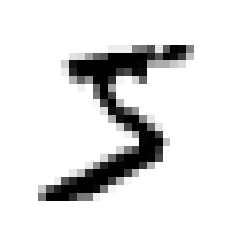

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
# notice above that the labes are strings, let's convert them into an int
import numpy as np

y = y.astype(np.uint8)

In [7]:
# split into train/test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [8]:
y_train_5 = (y_train == 5) # true for all 5s, false for all other digits
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures
### Measuring Accuracy Using Cross-Validation

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

In [15]:
# this has a 90% accuracy measure because we are always guessing that the number is not a 5,
# and about 90% of the dataset are not 5s.  So, accuracy usually isn't the best performance measure
# for classifiers, especially when dealing with skewed datasets

## Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [17]:
from sklearn.metrics import confusion_matrix

# first row represents non-5 images, 53,892 images were correctly classified as non-5s while 687 were wrongly classified as 5s
# 2nd row represents 5s, 1,891 were wrongly classified as non 5s while 3,530 were correctly classified as 5s
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
y_train_perfect_predictions = y_train_5 # pretend we reach perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision and Recall

In [19]:
from sklearn.metrics import precision_score, recall_score

In [20]:
precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

In [22]:
# the F1 score is the harmonic mean of precision and recall.  Harmonic mean gives much more weight to low values,
# so you will only get a high F1 score if both precision and recall are high
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
# using cross_val_predict() function to get scores of all instances in training set, but specify
# that we want to return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

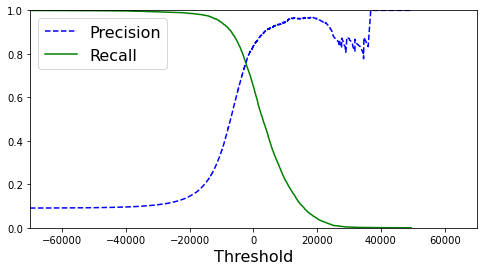

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold", fontsize = 16)
    plt.legend(loc = "upper left", fontsize = 16)
    plt.ylim([0, 1])
    
plt.figure(figsize = (8,4))

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-70000, 70000])
plt.show()

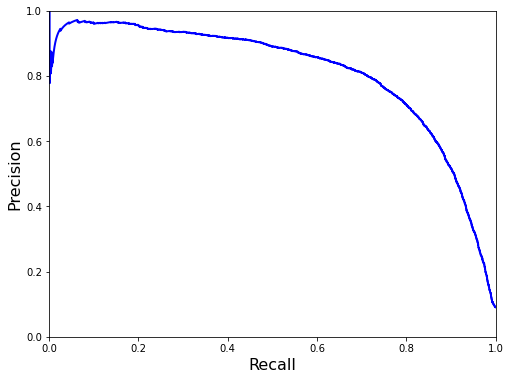

In [29]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth = 2)
    plt.xlabel("Recall", fontsize = 16)
    plt.ylabel("Precision", fontsize = 16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize = (8,6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [30]:
# suppose we aim for 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= .90)] # ~3370
threshold_90_precision

3370.0194991439557

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve (receiver operating characterisitc)

In [33]:
# Roc curve plts true positive rate (another name for recall)
# against the false positive rate.  FPR is the ration of negative instances that are incorrectly classified 
# as positive. FPR = 1 - true negative rate (specificity)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

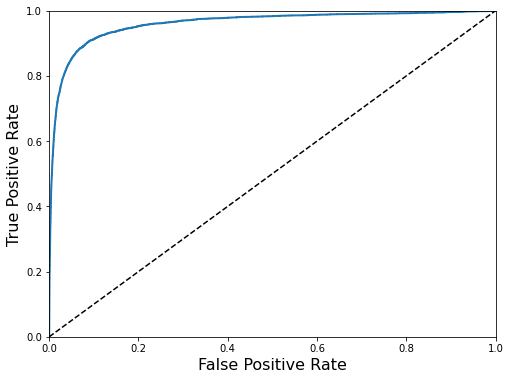

In [34]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.ylabel('True Positive Rate', fontsize = 16)
    
plt.figure(figsize = (8,6))
plot_roc_curve(fpr, tpr)
plt.show()

# the dotted line represents the ROC curve of a purely random classifier
# a good classifier stays far away from the dotted line

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [37]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positivity class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

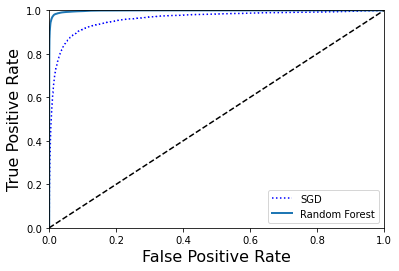

In [38]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [40]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)

In [41]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [42]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classification 

In [44]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [46]:
np.argmax(some_digit_scores)

5

In [47]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [48]:
# forcing skikit-learn to use OvR classifier
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [49]:
len(ovr_clf.estimators_)

10

In [50]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [51]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [52]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

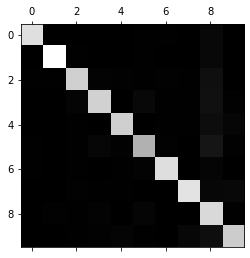

In [55]:
plt.matshow(conf_mx, cmap = plt.cm.gray)

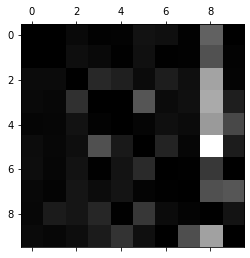

In [56]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
# calculate error rate: divide each val in conf_mx by num of images in corresponding class
norm_conf_mx = conf_mx / row_sums
# fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [58]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [59]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

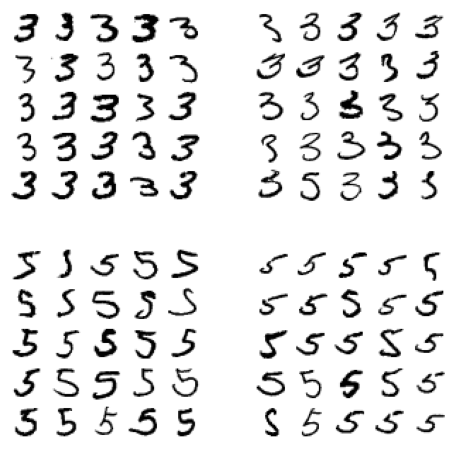

In [60]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# the two blocks on the left show digits classified as 3s, 
# and the 2 blocks on the right show images classified as 5s

## Multilabel Classification

In [61]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # is the digit large: 7, 8, or 9
y_train_odd = (y_train % 2 ==1) # is the digit odd
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [62]:
knn_clf.predict([some_digit]) # digit is not large, and digit is odd

array([[False,  True]])

In [63]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605

## Multioutput Classification

In [64]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

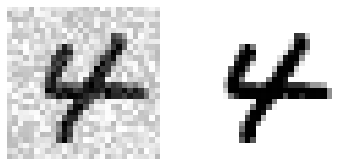

In [66]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)